In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
# 实例化RNN对象
# 第一个参数: input_size,hidden_size, layer_szie
rnn = nn.RNN(3, 8, 1, batch_first=True) # [B, T, input_size] [T, B, input_size]
# 输入张量x
# 第一个参数  sequenct_length(输入序列的长度)
# 第二个参数 batch_size (批次样本数)
# 第三个参数: input_size(输入张量维度)
input1 = torch.randn(5, 3, 3)
# 设置初始化h0
# 第一个参数 num_layer*num_directions(层数*网络方向数)
# 第二个参数: batch_size 样本数
# 第三个参数: 隐层节点数
h0 = torch.randn(1, 5, 8)
# 输入张量放入RNN.输出结果
output, hn = rnn(input1, h0)
print(output.shape)
# print()

torch.Size([5, 3, 8])


In [3]:
# 定义自定义的RNN模型
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        
        # 初始化参数
        self.hidden_size = hidden_size
        
        # 输入到隐藏层的线性变换 W_ih
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        # 隐藏层到输出层的线性变换 W_ho
        self.h2o = nn.Linear(hidden_size, output_size)
        
        # 激活函数
        self.tanh = nn.Tanh()
    
    # 前向传播
    def forward(self, input, hidden):
        # 拼接当前输入和上一时间步的隐藏状态
        combined = torch.cat((input, hidden), 1)
        
        # 计算当前时间步的隐藏状态
        hidden = self.tanh(self.i2h(combined))
        
        # 计算输出
        output = self.h2o(hidden)
        
        return output, hidden
    
    # 初始化隐藏状态
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
# 定义参数
input_size = 10   # 输入特征的维度
hidden_size = 20  # 隐藏状态的维度
output_size = 1   # 输出的维度


# 示例输入
input = torch.randn(1, input_size)  # 单个时间步的输入 (batch_size=1, input_size=10)
hidden = rnn.init_hidden()  # 初始化隐藏状态

# 执行前向传播
output, next_hidden = rnn(input, hidden)

# 打印结果
print("输出:", output)
print("下一时间步的隐藏状态:", next_hidden)

AttributeError: 'RNN' object has no attribute 'init_hidden'

In [3]:
# import torch
# import torch.nn as nn

# 定义 RNN 模型
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MyRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 定义 RNN 层
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # 定义输出层
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # RNN 前向传播
        out, _ = self.rnn(x, h0)
        
        # 取最后时间步的输出
        out = self.fc(out[:, -1, :])
        
        return out

# 定义参数
input_size = 10
hidden_size = 20
output_size = 1
num_layers = 2  # 使用2层RNN

# 创建模型
model = MyRNN(input_size, hidden_size, output_size, num_layers)

# 示例输入
input_seq = torch.randn(5, 3, input_size)  # (batch_size=5, seq_len=3, input_size=10)
# input_seq = torch.randn(3, 5, input_size)  # (batch_size=5, seq_len=3, input_size=10)

# 执行前向传播
output = model(input_seq)

print("输出:", output)


输出: tensor([[-0.0449],
        [-0.0884],
        [ 0.1350],
        [ 0.0698],
        [ 0.0034]], grad_fn=<AddmmBackward0>)


In [2]:
class CustomRNN:
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        # 初始化每一层的权重和偏置
        self.W_ih = []
        self.W_hh = []
        self.b_h = []
        
        for _ in range(num_layers):
            self.W_ih.append(torch.randn(hidden_size, input_size) * 0.01)  # 输入到隐藏层的权重
            self.W_hh.append(torch.randn(hidden_size, hidden_size) * 0.01)  # 隐藏层到隐藏层的权重
            self.b_h.append(torch.zeros(hidden_size))  # 隐藏层偏置
            input_size = hidden_size  # 除第一层外，后面各层的输入为hidden_size
        
        self.W_ih = torch.nn.ParameterList([torch.nn.Parameter(w) for w in self.W_ih])
        self.W_hh = torch.nn.ParameterList([torch.nn.Parameter(w) for w in self.W_hh])
        self.b_h = torch.nn.ParameterList([torch.nn.Parameter(b) for b in self.b_h])

    def forward(self, inputs, hidden=None):
        # 处理批次和序列维度
        if self.batch_first:
            batch_size, seq_len, _ = inputs.size()
            
        else:
            seq_len, batch_size, _ = inputs.size()
            inputs = inputs.transpose(0, 1)
        # print(f"batch_size: {batch_size}, seq_len: {seq_len}")
        # 初始化隐藏状态
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        
        outputs = []
        print(inputs.shape)
        # 对每个时间步进行遍历
        for t in range(seq_len):
            x_t = inputs[:, t, :]
            # print(f"x_t: {x_t.shape}")
            for layer in range(self.num_layers):
                h_prev = hidden[layer]
                h_t = torch.tanh(torch.mm(x_t, self.W_ih[layer].t()) + torch.mm(h_prev, self.W_hh[layer].t()) + self.b_h[layer])
                hidden[layer] = h_t
                x_t = h_t  # 当前层的输出作为下一层的输入
                # print(f"循环内: {h_t.shape}")
            outputs.append(h_t.unsqueeze(1))  # 收集每个时间步的输出
        
        outputs = torch.cat(outputs, dim=1)  # 将每个时间步的输出合并
        # print(f"outputs: {outputs.shape}")
        # print(f"hidden: {hidden[0].shape}")
        return outputs, hidden


In [3]:
# 示例：定义参数并运行模型
input_size = 3
hidden_size = 8
num_layers = 1
batch_size = 5
seq_len = 4

# 初始化自定义RNN
model = CustomRNN(input_size, hidden_size, num_layers, batch_first=False)

# 生成随机输入
# input_seq = torch.randn(batch_size, seq_len, input_size)
input_seq = torch.randn(seq_len, batch_size, input_size)

# 执行前向传播
output, hidden = model.forward(input_seq)

print(f"输入的数据形状: {input_seq.shape}")
print("输出维度:", output.shape)
# print("输出:", output)


torch.Size([5, 4, 3])
输入的数据形状: torch.Size([4, 5, 3])
输出维度: torch.Size([5, 4, 8])


In [ ]:
# 实例化RNN对象
# 第一个参数: input_size,hidden_size, layer_szie
rnn = nn.RNN(3, 3, 1) # [B, T, input_size] [T, B, input_size]
# 输入张量x
# 第一个参数  sequenct_length(输入序列的长度)
# 第二个参数 batch_size (批次样本数)
# 第三个参数: input_size(输入张量维度)
input1 = torch.randn(3, 1, 3)
# 设置初始化h0
# 第一个参数 num_layer*num_directions(层数*网络方向数)
# 第二个参数: batch_size 样本数
# 第三个参数: 隐层节点数
h0 = torch.randn(1, 1, 3)
# 输入张量放入RNN.输出结果
output, hn = rnn(input1, h0)
print(output.shape)    # ---> torch.Size([3, 1, 3])
# print()

In [8]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layers_size,first_batch=False):
        super(MyRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers_size = layers_size
        self.first_batch = first_batch

        self.w_in = []
        self.w_hh = []
        self.bh = []

        for layers in range(self.layers_size):
            self.w_in.append(torch.randn([hidden_size, input_size])*0.01)
            self.w_hh.append(torch.randn([hidden_size, hidden_size])*0.01)
            self.bh.append(torch.zeros(hidden_size))
            input_size = hidden_size # 除了第一层，输入与隐层相等
        self.w_in = nn.ParameterList([nn.Parameter(w) for w in self.w_in])
        self.w_hh = nn.ParameterList([nn.Parameter(w) for w in self.w_hh])
        self.bh = nn.ParameterList([nn.Parameter(b) for b in self.bh])

    def forward(self, inputs, hidden=None):
        if self.first_batch:
            batch_size, seq_len, _ = inputs.size()
        else:
            seq_len, batch_size, _ = inputs.size()
            inputs = inputs.transpose(0, 1)

        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.layers_size)]

        outputs = []
        # print(inputs.shape)
        for t in range(seq_len):
            x = inputs[:, t, :]
            for layer in range(self.layers_size):
                h_pre = hidden[layer]
                h_t = torch.tanh(torch.mm(x, self.w_in[layer].t()) + torch.mm(h_pre, self.w_hh[layer].t()) + self.bh[layer])
                hidden[layer] = h_t
                x = h_t
            outputs.append(h_t.unsqueeze(1))
        outputs = torch.cat(outputs, dim=1)
        if self.first_batch:
            outputs = outputs.transpose(0, 1)
        return outputs, hidden

In [9]:
# 示例：定义参数并运行模型
input_size = 3
hidden_size = 8
num_layers = 1
batch_size = 5
seq_len = 3

# 初始化自定义RNN
model = MyRNN(input_size, hidden_size, num_layers, first_batch=True)

# 生成随机输入
# input_seq = torch.randn(batch_size, seq_len, input_size)
input_seq = torch.randn(seq_len, batch_size, input_size)

# 执行前向传播
output, hidden = model(input_seq)

print(f"输入的数据形状: {input_seq.shape}")
print("输出维度:", output.shape)
print("输出:", output.shape)

输入的数据形状: torch.Size([3, 5, 3])
输出维度: torch.Size([5, 3, 8])
输出: torch.Size([5, 3, 8])


# 人名分类

## 1.导包

In [1]:
# 从io中导入文件打开方法
from io import open
# 帮助使用正则表达式进行子目录的查询
import glob
import os
# 用于获得常见字母及字符规范化
import string
import unicodedata
# 导入随机工具random
import random
# 导入时间和数学工具包
import time
import math
# 导入torch工具
import torch
# 导入nn准备构建模型
import torch.nn as nn
# 引入制图工具包        
import matplotlib.pyplot as plt


## 2. 准备数据集

In [2]:
# 获取所有常用字符包括字母和常用标点
all_letters = string.ascii_letters + " .,;'"

# 获取常用字符数量
n_letters = len(all_letters)

print("n_letter:", n_letters)


n_letter: 57


In [3]:
# 关于编码问题我们暂且不去考虑
# 我们认为这个函数的作用就是去掉一些语言中的重音标记
# 如: Ślusàrski ---> Slusarski
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [4]:
s = "Ślusàrski"
a = unicodeToAscii(s)
print(a)


Slusarski


In [5]:
data_path = "./data/data/names/"

def readLines(filename):
    """从文件中读取每一行加载到内存中形成列表"""
    # 打开指定文件并读取所有内容, 使用strip()去除两侧空白符, 然后以'\n'进行切分
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    # 对应每一个lines列表中的名字进行Ascii转换, 使其规范化.最后返回一个名字列表
    return [unicodeToAscii(line) for line in lines]


In [6]:
# filename是数据集中某个具体的文件, 我们这里选择Chinese.txt
filename = data_path + "Chinese.txt"
print(f"读取的地址: {filename}")
lines = readLines(filename)
print(len(lines))
print(lines)


读取的地址: ./data/data/names/Chinese.txt
268
['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao', 'Cen', 'Chai', 'Chaim', 'Chan', 'Chang', 'Chao', 'Che', 'Chen', 'Cheng', 'Cheung', 'Chew', 'Chieu', 'Chin', 'Chong', 'Chou', 'Chu', 'Cui', 'Dai', 'Deng', 'Ding', 'Dong', 'Dou', 'Duan', 'Eng', 'Fan', 'Fei', 'Feng', 'Foong', 'Fung', 'Gan', 'Gauk', 'Geng', 'Gim', 'Gok', 'Gong', 'Guan', 'Guang', 'Guo', 'Gwock', 'Han', 'Hang', 'Hao', 'Hew', 'Hiu', 'Hong', 'Hor', 'Hsiao', 'Hua', 'Huan', 'Huang', 'Hui', 'Huie', 'Huo', 'Jia', 'Jiang', 'Jin', 'Jing', 'Joe', 'Kang', 'Kau', 'Khoo', 'Khu', 'Kong', 'Koo', 'Kwan', 'Kwei', 'Kwong', 'Lai', 'Lam', 'Lang', 'Lau', 'Law', 'Lew', 'Lian', 'Liao', 'Lim', 'Lin', 'Ling', 'Liu', 'Loh', 'Long', 'Loong', 'Luo', 'Mah', 'Mai', 'Mak', 'Mao', 'Mar', 'Mei', 'Meng', 'Miao', 'Min', 'Ming', 'Moy', 'Mui', 'Nie', 'Niu', 'OuYang', 'OwYang', 'Pan', 'Pang', 'Pei', 'Peng', 'Ping', 'Qian', 'Qin', 'Qiu', 'Quan', 'Que', 'Ran', 'Rao', 'Rong', 'Ruan', 'Sam', 'Seah', '

In [7]:
category_lines = {}
all_categories = []

for filename in glob.glob(data_path+"*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# 查看总类别
n_categories = len(all_categories)
print("n_categories: ", n_categories)
# 打印其中一个文件的内容
print(category_lines["Italian"][:5])

n_categories:  18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [8]:
# 构建的category_lines形如：{"English":["Lily", "Susan", "Kobe"], "Chinese":["Zhang San", "Xiao Ming"]}
category_lines = {}

# all_categories形如： ["English",...,"Chinese"]
all_categories = []

# 读取指定路径下的txt文件， 使用glob，可以在path中使用正则表达式
for filename in glob.glob(data_path + '*.txt'):
    # 获取每个文件的文件名, 就是对应的名字类别
    # os.path.basename() 获取文件名 如 chinese.txt
    # os.path.splitext(), 按.进行切分 [chinese, txt]
    category = os.path.splitext(os.path.basename(filename))[0]
    # 将其逐一装到all_categories列表中
    all_categories.append(category)
    # 然后读取每个文件的内容，形成名字列表
    lines = readLines(filename)
    # 按照对应的类别，将名字列表写入到category_lines字典中
    category_lines[category] = lines


# 查看类别总数
n_categories = len(all_categories)
print("n_categories:", n_categories)

# 随便查看其中的一些内容
print(category_lines['Italian'][:5]) 


n_categories: 18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [9]:
# 将对应名字转换为张量
# 将字符串(单词粒度)转化为张量表示，如："ab" --->
# tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0.]],

#        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0.]]])
def lineToTensor(line):
    """将人名转化为对应onehot张量表示, 参数line是输入的人名"""
    # 首先初始化一个0张量, 它的形状(len(line), 1, n_letters) 
    # 代表人名中的每个字母用一个1 x n_letters的张量表示.
    tensor = torch.zeros(len(line), 1, n_letters)
    # 遍历这个人名中的每个字符索引和字符
    for li, letter in enumerate(line):
        # 使用字符串方法find找到每个字符在all_letters中的索引
        # 它也是我们生成onehot张量中1的索引位置
        tensor[li][0][all_letters.find(letter)] = 1
    # 返回结果
    return tensor


In [1]:
import fasttext

## 使用视频的构建RNN的方式

In [10]:
class my_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(my_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # 定义网络结构 实例化
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        # 实例化全连接线性层---将RNN的输出维度转换成指定维度
        self.linear = nn.Linear(hidden_size, output_size)
        # 实例化nn中预定义softmax层,用于输出层中获得类别的结果
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input1, hidden):
        # input1: 代表人名分类器中输入张量,形状是1*n_letter
        # hidden 代表隐层张量, 形状 self.num_layers*1*self.hidden_size
        # 注意: 输入的张量必须是三维，因此需要扩充维度
        input1 = input1.unsqueeze(0)
        # 将 input1和 hidden输入到RNN对象中，如果 num_layers==1, rr恒等hn
        rr, hn = self.rnn(input1, hidden)
        # 将从RNN中获得的结果通过线性变换和softmax的处理
        return self.softmax(self.linear(rr)), hn

    def initHidden(self):
        # 初始化全0的隐藏层张量, 维度3
        return torch.zeros(self.num_layers, 1, self.hidden_size)

In [11]:
class my_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(my_LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # 定义网络结构
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers)
        # 定义全连接
        self.linear = nn.Linear(hidden_size, output_size)
        # 实例化激活函数
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input1, hidden, c):
        # LSTM网络的输入是三个张量,尤其不要忘记细胞状态
        input1 = input1.unsqueeze(0)

        rr, (hn, cn) = self.lstm(input1, (hidden, c))
        return self.softmax(self.linear(rr)), hn, cn

    def initHiddenAndC(self):
        # 注意: lstm初始化时,要同时初始化hidden C
        c = hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        return hidden, c

In [12]:
class my_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(my_GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input1, hidden):
        input1 = input1.unsqueeze(0)
        rr, hn = self.gru(input1, hidden)
        return self.softmax(self.linear(rr)), hn

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

In [13]:
# 实例化参数
# 因为是one-hot编码, 输入张量最后一维尺寸就是n_letter
input_size = n_letters

# 定义隐层最后一维尺寸
n_hidden = 128
# 输出尺寸为语言类别总数 n_categories
output_size = n_categories

# num_layers使用默认值, num_layers=1

In [14]:
# 实例化网络层
rnn = my_RNN(input_size, n_hidden, output_size)

In [15]:
lstm = my_LSTM(input_size, n_hidden, output_size)
gru = my_GRU(input_size, n_hidden, output_size)

## 构建训练函数并进行训练

In [16]:
# 从输出的结果中获得指定的类别函数---辅助函数
def categoryFromOutput(output):
    # output从输出中得到指定的类别
    # 需要调用topk, 得到最大的值和索引，作为类别信息
    top_n, top_i = output.topk(1)
    # 从top_i中取出索引值
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [17]:
# 数据生成函数
def randomTrainingExample():
    # 用于随机产生训练数据
    # 第一步使用random.choice()方法从 all_categories随机选择一个类别
    category = random.choice(all_categories)
    # 第二步通过 categry_lines字典取出 categry类别对应的名字
    line = random.choice(category_lines[category])
    # 第三步将类别封装成tensor
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    # 第四步将随机取到的名字通过函数LineToTensor转换为张量
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [18]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f"category: {category}, / line = {line} / category_tensor: {category_tensor}")
print(f"line_tensor: {line_tensor.shape}")

category: Spanish, / line = Porras / category_tensor: tensor([16])
category: Polish, / line = Jedynak / category_tensor: tensor([12])
category: Spanish, / line = Silva / category_tensor: tensor([16])
category: English, / line = Elworthy / category_tensor: tensor([4])
category: German, / line = Steuben / category_tensor: tensor([6])
category: Korean, / line = Nam / category_tensor: tensor([11])
category: Korean, / line = Chung / category_tensor: tensor([11])
category: Arabic, / line = Ghanem / category_tensor: tensor([0])
category: Dutch, / line = Klerkx / category_tensor: tensor([3])
category: Dutch, / line = Meeuwessen / category_tensor: tensor([3])
line_tensor: torch.Size([10, 1, 57])


In [19]:
# 定义损失函数为nn.NLLLoss,因为RNN的最后一层是nn.LogSoftmax, 两者的内部计算逻辑吻合
criterion = nn.NLLLoss()
# 设置学习率
lr = 0.005

In [20]:
def trainRNN(category_tensor, line_tensor):
    # category_tensor 代表训练数据的标签
    # line_tensor 代表训练数据的特征
    # 第一步，初始化一个RNN的隐层张量
    hidden = rnn.initHidden()
    # 关键的一步: 将模型中的梯度归0
    rnn.zero_grad()
    # 循环遍历数据中 line_tensor 中每一个字符，传入RNN, 并迭代更新hidden
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    # 因为RNN的输出是三维，需要降维
    loss = criterion(output.squeeze(0), category_tensor)

    # 进行反向传播
    loss.backward()

    # 显式更新模型中参数
    for p in rnn.parameters():
        # 将参数的张量表示与参数的梯度进行乘法运算并乘以学习率，结果加到参数上，并进行覆盖的更新
        p.data.add_(p.grad.data, alpha=-lr)

    # 返回最终输出结果
    return output, loss.item()

In [21]:
def trainLSTM(category_tensor, line_tensor):
    # 初始化隐层张量, 以及细胞状态
    hidden, c = lstm.initHiddenAndC()
    lstm.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden, c = lstm(line_tensor[i], hidden, c)

    loss =criterion(output.squeeze(0), category_tensor)
    loss.backward()

    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()

In [22]:
# 每次只能训练一个样本
def trainGRU(category_tensor, line_tensor):
    hidden = gru.initHidden()
    gru.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output.squeeze(0), category_tensor)
    loss.backward()
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    return output, loss.item()

In [23]:
# 构建时间计算函数
def timeSince(since):
    # 本函数作用打印每次训练的耗时--since是训练开始时间
    # 第一步获取当前时间
    now = time.time()
    # 第二步得到时间差
    s = now - since
    # 第三步计算得到分钟数
    m = math.floor(s / 60)
    # 第四步得到秒数
    s -= m * 60
    return "%dm %ds" % (m, s)

In [24]:
since = time.time() - 10 * 60
priod = timeSince(since)
print(priod)

10m 0s


In [25]:
# 设置训练迭代次数
n_iters = 1000
# 设置结果的打印间隔
print_every = 2
# 设置绘制损失函数曲线上的制图间隔
plot_every = 5

In [26]:
def train(train_type_fn):
    # 选择哪种模型训练
    # 初始化存储每个制图间隔损失的列表
    all_loss = []
    # 获取训练开始时间
    start = time.time()
    # 设置初始间隔的损失值为0
    current_loss = 0
    # 迭代训练
    for iter in range(1, n_iters + 1):
        # 通过randomTrainingExample随机获取一组训练数据和标签
        category, line, category_tensor, line_tensor = randomTrainingExample()
        # 将训练特征和标签传入模型
        output, loss = train_type_fn(category_tensor, line_tensor)
        current_loss += loss

        # 如果到了迭代次数打印间隔
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            # 判断和真实类别标签进行比较,如果相同为true,否则为false
            correct = "True" if guess == category else "False (%s)" % category
            # 打印若干信息
            print("%d %d%% (%s) %.4f %s / %s %s" % (iter, iter/n_iters*100, timeSince(start), loss, line, guess, correct))

        if iter % plot_every == 0:
            # 将过去若干论的平均损失添加列表
            all_loss.append(current_loss / plot_every)
            current_loss = 0

    return all_loss, int(time.time() - start)

2 0% (0m 1s) 2.8685 Adelardi / Scottish False (Italian)
4 0% (0m 1s) 2.8956 Heppenheimer / Scottish False (German)
6 0% (0m 1s) 2.8468 Winograd / Scottish False (Polish)
8 0% (0m 1s) 2.7892 Skala / Scottish False (Polish)
10 1% (0m 1s) 2.8303 Meeuwissen / Scottish False (Dutch)
12 1% (0m 1s) 2.9408 Bertsimas / French False (Greek)
14 1% (0m 1s) 2.9290 Hajjar / Scottish False (Arabic)
16 1% (0m 1s) 2.9058 Mikhail / Scottish False (Arabic)
18 1% (0m 1s) 2.9419 Casey / French False (Irish)
20 2% (0m 1s) 2.7712 Munro / Scottish True
22 2% (0m 1s) 2.8575 Nghiem / Scottish False (Vietnamese)
24 2% (0m 1s) 2.7723 Douglas / French False (Scottish)
26 2% (0m 1s) 2.9066 Purse / Scottish False (English)
28 2% (0m 1s) 2.9034 Matocha / Scottish False (Czech)
30 3% (0m 1s) 2.9439 Jia / Scottish False (Chinese)
32 3% (0m 1s) 2.8640 Rao / Scottish False (Italian)
34 3% (0m 1s) 2.9823 Crespo / Scottish False (Portuguese)
36 3% (0m 1s) 2.8717 Riedel / Scottish False (Czech)
38 3% (0m 1s) 2.8283 O'Drisco

<BarContainer object of 3 artists>

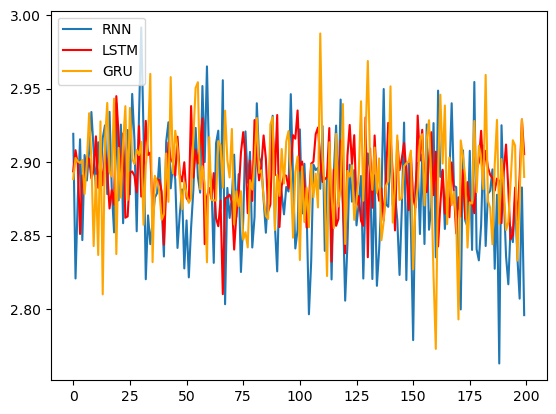

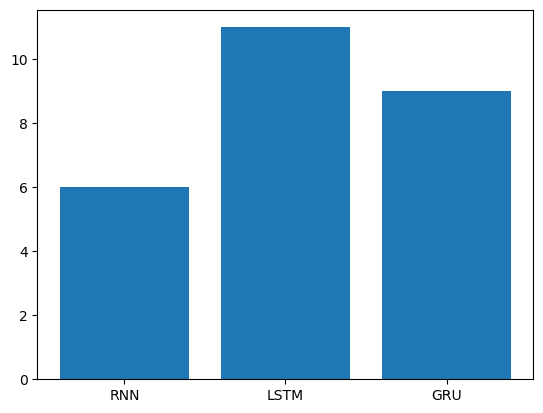

In [27]:
# 调用train函数
all_loss1, period1 = train(trainRNN)
all_loss2, period2 = train(trainLSTM)
all_loss3, period3 = train(trainGRU)

# 绘制损失对比曲线
plt.figure(0)
plt.plot(all_loss1, label="RNN")
plt.plot(all_loss2, label="LSTM", color="red")
plt.plot(all_loss3, label="GRU", color="orange")
plt.legend(loc="upper left")

# 绘制训练耗时柱状图
plt.figure(1)
x_data = ["RNN", "LSTM", "GRU"]
y_data = [period1, period2, period3]
plt.bar(range(len(x_data)), y_data, tick_label=x_data)

## 构建评估函数

In [28]:
# 构建RNN的评估函数
def evaluateRNN(line_tensor):
    # 评估函数仅有一个参数--代表名字的张量表示
    # 初始化隐层张量
    hidden = rnn.initHidden()
    # 评估数据 line_tensor 中的每一个字符逐个传入RNN
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        # 返回整个RNN的输出
        return output.squeeze(0)

In [29]:
def evaluateLSTM(line_tensor):
    hidden, c = lstm.initHiddenAndC()
    for i in range(line_tensor.size()[0]):
        output, hidden, c = lstm(line_tensor[i], hidden, c)
    return output.squeeze(0)

In [30]:
def evaluateGRU(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output.squeeze(0)

In [31]:
line = "Bai"
line_tensor = lineToTensor(line)
rnn_output = evaluateRNN(line_tensor)
lstm_output = evaluateLSTM(line_tensor)
gru_output = evaluateGRU(line_tensor)
print(f"rnn_output: {rnn_output}")
print(f"lstm_output: {lstm_output}")
print(f"gru_output: {gru_output}")

rnn_output: tensor([[-2.8883, -2.9496, -2.9022, -2.8385, -2.9832, -2.6978, -2.9537, -2.8288,
         -2.8081, -2.9519, -2.9518, -2.9364, -2.9343, -2.9051, -2.9004, -2.8148,
         -2.9208, -2.9048]], grad_fn=<SqueezeBackward1>)
lstm_output: tensor([[-2.8336, -2.9593, -2.9580, -2.8241, -3.0283, -2.8932, -2.8978, -2.8613,
         -2.8302, -2.7948, -2.8669, -2.9672, -2.9516, -2.9076, -2.8313, -2.8969,
         -2.8657, -2.8907]], grad_fn=<SqueezeBackward1>)
gru_output: tensor([[-2.8639, -2.8634, -2.8282, -2.9554, -2.8716, -2.9315, -3.0237, -2.9100,
         -2.8806, -2.9759, -2.9371, -2.8056, -2.8222, -2.9895, -2.8216, -2.8160,
         -2.8211, -2.9486]], grad_fn=<SqueezeBackward1>)


## 构建预测函数

In [32]:
def predict(input_line, evaluate_fn, n_predictions=3):
    # input_line 代表输入字符串名字
    # evaluate_fn 代表评估函数
    # n_predictions 代表需要取得最有可能的 n_predictions个结果
    # 首先将输入的名字打印出来
    print("\n> %s" % input_line)
    # 所有的预测函数不改变模型参数
    with torch.no_grad():
        # 使用输入的人名转换成张量,然后调用评估函数得到预测结果
        output = evaluate_fn(lineToTensor(input_line))

        # 从预测结果中取出top3个最大值及其索引
        topv, topi = output.topk(n_predictions, 1, True)
        # 初始化结果列表
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            # 然后从topi中取出索引值
            category_index = topi[0][i].item()
            # 打印概率值及其对应的真实国家名称
            print("(%.2f) %s" % (value, all_categories[category_index]))
            # 将结果封装列表,添加到最终结果列表中
            predictions.append([value, all_categories[category_index]])
        return predictions

In [34]:
for evaluate_fn in [evaluateRNN, evaluateLSTM, evaluateGRU]:
    print("*"*20)
    predict("Dovesky", evaluate_fn)
    predict("Jackson", evaluate_fn)
    predict("Satoshi", evaluate_fn)

********************

> Dovesky
(-2.78) French
(-2.80) Scottish
(-2.80) Irish

> Jackson
(-2.76) Scottish
(-2.77) French
(-2.81) Vietnamese

> Satoshi
(-2.75) French
(-2.79) Scottish
(-2.85) Italian
********************

> Dovesky
(-2.80) Irish
(-2.81) Dutch
(-2.81) Italian

> Jackson
(-2.79) Italian
(-2.81) Dutch
(-2.82) Irish

> Satoshi
(-2.79) Italian
(-2.81) Dutch
(-2.82) Irish
********************

> Dovesky
(-2.81) Spanish
(-2.82) English
(-2.82) Korean

> Jackson
(-2.78) Korean
(-2.79) Spanish
(-2.82) Czech

> Satoshi
(-2.79) Korean
(-2.80) Russian
(-2.81) Scottish


In [ ]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1

    return tensor

In [44]:
a = torch.rand(4)
print(a)
b = torch.rand(4, 1)
print(b)
print("-" * 10)
c = torch.add(a, b)
print(c)
d = torch.add(a, b, alpha=10)
print(d)

tensor([0.3697, 0.8067, 0.8485, 0.3402])
tensor([[0.0514],
        [0.5652],
        [0.4547],
        [0.5449]])
----------
tensor([[0.4211, 0.8581, 0.8999, 0.3916],
        [0.9349, 1.3718, 1.4136, 0.9053],
        [0.8244, 1.2614, 1.3032, 0.7949],
        [0.9146, 1.3515, 1.3933, 0.8850]])
tensor([[0.8841, 1.3211, 1.3629, 0.8546],
        [6.0212, 6.4582, 6.5000, 5.9917],
        [4.9168, 5.3537, 5.3955, 4.8872],
        [5.8183, 6.2553, 6.2970, 5.7888]])


In [35]:
x = torch.arange(1., 6.)
# torch.topk(x, 3)
values, index = torch.topk(x, 3)
print(values)
print(index)

tensor([5., 4., 3.])
tensor([4, 3, 2])


In [ ]:
torch.return_types.topk(
values=tensor([5., 4., 3.]),
indices=tensor([4, 3, 2]))